In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd # data frame
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import tqdm as tqdm
import PIL
from PIL import Image, ImageOps
import cv2
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

# plt.style.use('seaborn')
# sns.set(font_scale=2.5)

import missingno as msno # null data를 보여줌

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def seed_everything(seed):
    """
    동일한 조건으로 학습을 할 때, 동일한 결과를 얻기 위해 seed를 고정시킵니다.
    
    Args:
        seed: seed 정수값
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
seed_everything(42)

In [3]:
df_train = pd.read_csv('input/data/train/train.csv')

## Augmentation

In [4]:
def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = A.Compose([
            A.Resize(img_size[0], img_size[1], p=1.0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.CenterCrop(height=300, width=225),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.GaussNoise(p=0.5),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = A.Compose([
            A.Resize(img_size[0], img_size[1]),
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

## Dataset

In [5]:
class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2
    
class GenderLabels:
    male = 0
    female = 1
    
class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 58 else 2

In [6]:
class myDataset(Dataset):
    num_classes = 18
    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal,
#         "mask1.png": MaskLabels.mask,
#         "mask2.png": MaskLabels.mask,
#         "mask3.png": MaskLabels.mask,
#         "mask4.png": MaskLabels.mask,
#         "mask5.png": MaskLabels.mask,
#         "incorrect_mask.png": MaskLabels.incorrect,
#         "normal.png": MaskLabels.normal,
#         "mask1.jpeg": MaskLabels.mask,
#         "mask2.jpeg": MaskLabels.mask,
#         "mask3.jpeg": MaskLabels.mask,
#         "mask4.jpeg": MaskLabels.mask,
#         "mask5.jpeg": MaskLabels.mask,
#         "incorrect_mask.jpeg": MaskLabels.incorrect,
#         "normal.jpeg": MaskLabels.normal
    }
    
    img_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform
        self.setup()
    
    def set_transform(self, transform):
        self.transform = transform
    
    def setup(self):
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)
                if os.path.exists(img_path):
                    self.img_paths.append(img_path)
                    self.mask_labels.append(label)
                    
                    id, gender, race, age = profile.split('_')
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)
                    
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)
                    
    def __getitem__(self, index):
        # load image
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        # load label
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label*6 + gender_label*3 + age_label
        
        # image augmentation
        img_transform = self.transform(image=np.array(img))['image']
        return img_transform, multi_class_label
    
    def __len__(self):
        return len(self.img_paths)

In [7]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
img_dir = 'input/data/train/images'

transform = get_transforms(mean=mean, std=std)

dataset = myDataset(img_dir=img_dir)

n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

## DataLoader

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

In [9]:
images, labels = next(iter(train_loader))
print('images shape:', images.shape)
print('labels shape:', labels.shape)

images shape: torch.Size([12, 3, 300, 225])
labels shape: torch.Size([12])


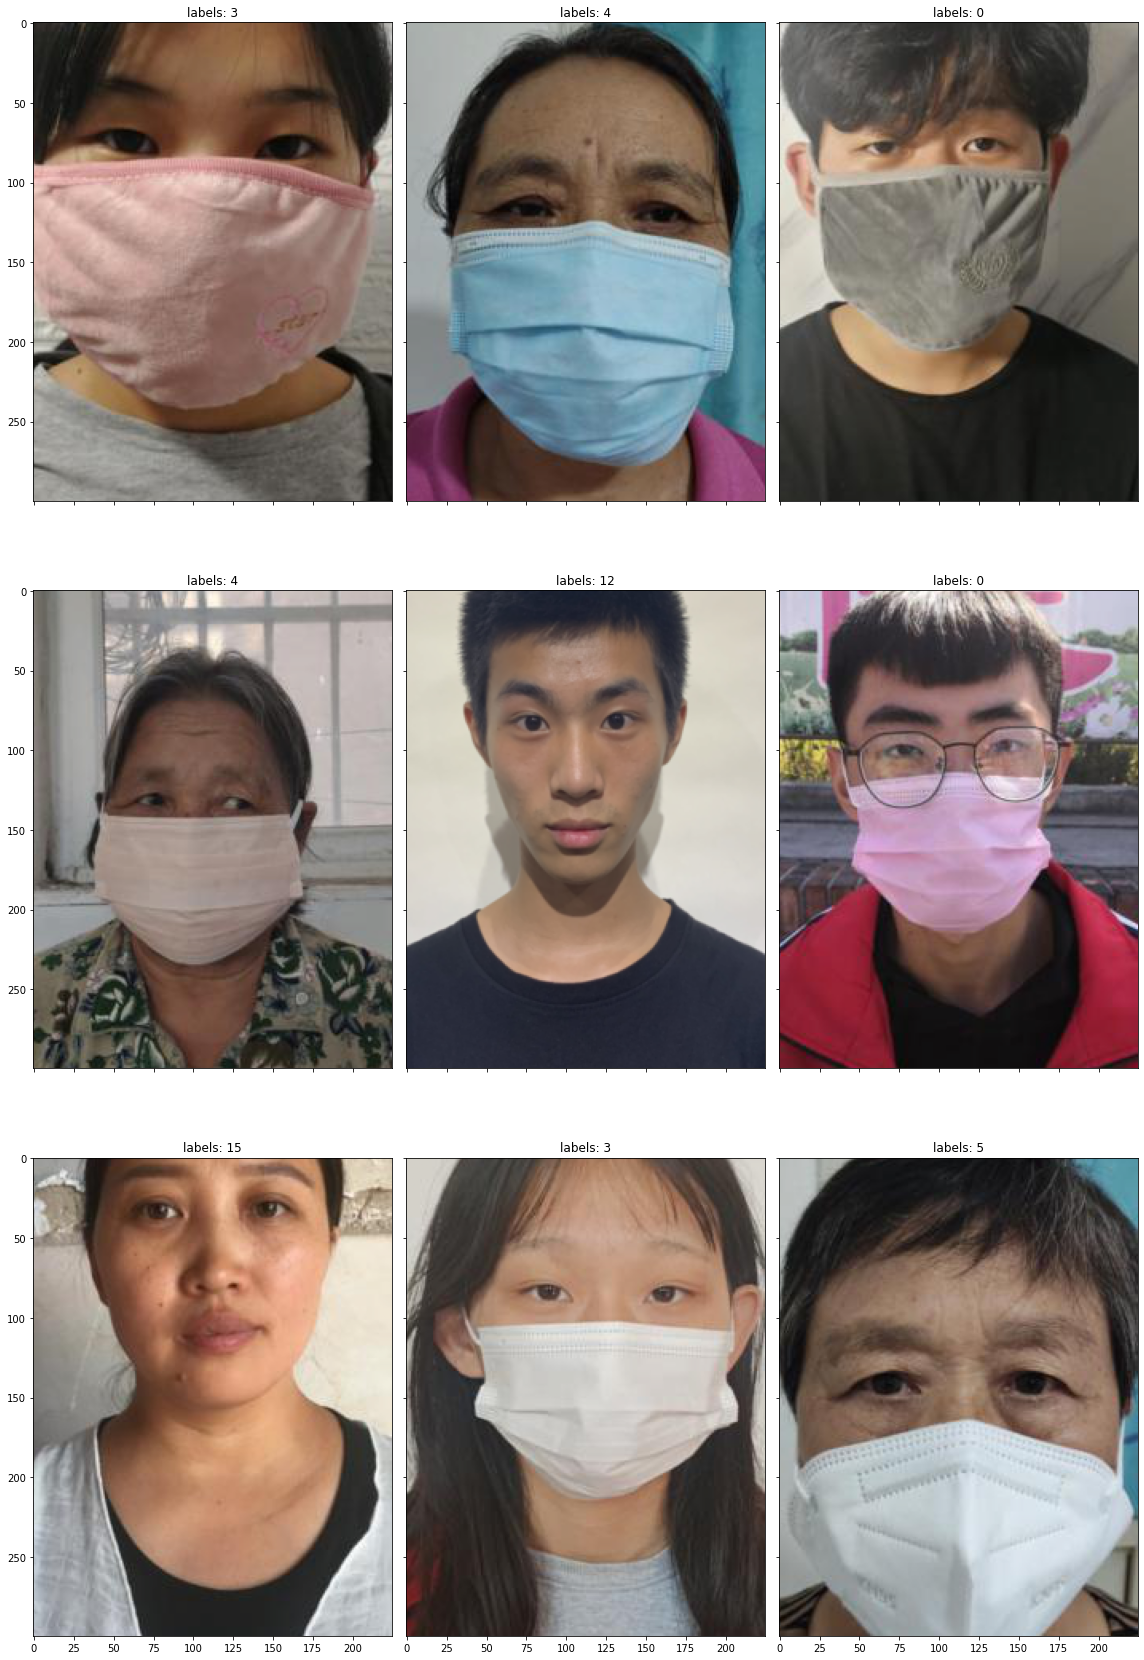

In [10]:
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

f, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 24))
idx = 0
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(inv_normalize(images[idx]).permute(1, 2, 0))
        ax[i, j].set_title(f'labels: {labels[idx]}')
        idx += 1
plt.tight_layout()

## Train

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        since = time.time()
        
        # each epoch has step & validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # reapeat
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=-1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
        print()
        
    print(f'Best val Acc: {best_acc}')
    
    model.load_state_dict(best_model_weights)
    return model

## Loss

In [13]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=18, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [15]:
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [16]:
from torch.optim import lr_scheduler
from efficientnet_pytorch import EfficientNet
from adamp import AdamP
import timm
import madgrad

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18)
# model = timm.create_model('vit_base_patch32_384', pretrained=True)
model = model.to(device)

dataloaders = {'train':train_loader, 'val': val_loader}

criterion = LabelSmoothingLoss()
# optimizer = AdamP(model.parameters(), lr=1e-5)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)

Loaded pretrained weights for efficientnet-b0


In [17]:
model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.6025 Acc: 0.7820
val Loss: 0.3272 Acc: 0.8683
Training complete in 1.0m 44.78332710266113s

Epoch 1/11
----------
train Loss: 0.2606 Acc: 0.8998
val Loss: 0.1963 Acc: 0.9209
Training complete in 1.0m 43.69767498970032s

Epoch 2/11
----------
train Loss: 0.0976 Acc: 0.9673
val Loss: 0.1092 Acc: 0.9563
Training complete in 1.0m 43.57988405227661s

Epoch 3/11
----------
train Loss: 0.2000 Acc: 0.9289
val Loss: 0.1680 Acc: 0.9426
Training complete in 1.0m 44.53617715835571s

Epoch 4/11
----------
train Loss: 0.0858 Acc: 0.9698
val Loss: 0.1358 Acc: 0.9566
Training complete in 1.0m 43.207947731018066s

Epoch 5/11
----------
train Loss: 0.0264 Acc: 0.9923
val Loss: 0.0534 Acc: 0.9812
Training complete in 1.0m 42.837947607040405s

Epoch 6/11
----------
train Loss: 0.1385 Acc: 0.9513
val Loss: 0.1633 Acc: 0.9444
Training complete in 1.0m 43.43129897117615s

Epoch 7/11
----------
train Loss: 0.0575 Acc: 0.9812
val Loss: 0.0925 Acc: 0.9733
Training complete in

## Visualize

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    f = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=-1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

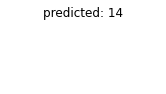

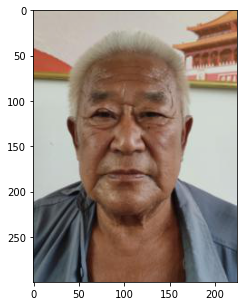

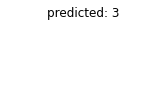

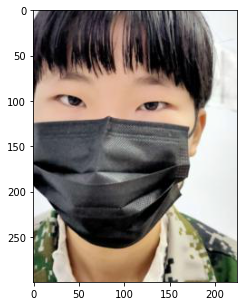

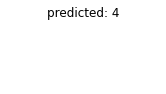

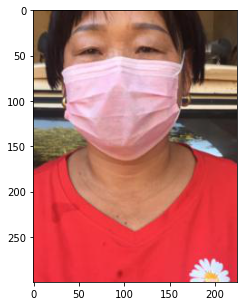

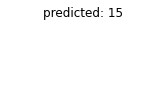

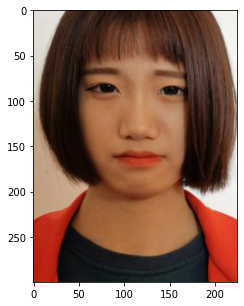

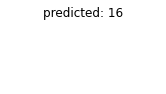

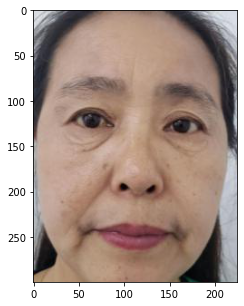

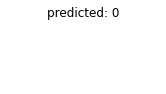

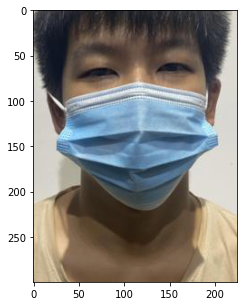

In [20]:
visualize_model(model)

## Test

In [21]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [22]:
test_dir = '/opt/ml/input/data/eval'

In [23]:
from torchvision.transforms import Resize, ToTensor, Normalize

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!


## Hyperparameter log

In [24]:
# import neptune

# ns = neptune.init(project_qualified_name=f'ssun-g/pstage1', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNDkzZTAxOS02NTM3LTRmZTMtODZhMi0wY2JkYzFiYzE3MDMifQ==')

# neptune.create_experiment('onlyjpg_efficientnet_Adam_FocalLoss_CosineAnnealingLR')

# neptune.log_metric('learning_rate', 0.0003)
# neptune.log_metric('weight_decay', 5e-4)
# neptune.log_metric('num_epochs', 15)
# neptune.log_metric('scheduler_T_max', 2)
# neptune.log_metric('batch_size', 12)
# neptune.log_metric('num_workers', 4)

In [25]:
from IPython.display import Audio
Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg", autoplay=True)